In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from IPython.display import HTML
#from IPython.display import display, clear_output
import PIL
import numpy as np
import pandas as pd
import scipy as sp
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable
from IPython.display import display, clear_output
import os
from scipy import stats

# Load Data

In [3]:
os.environ["L5KIT_DATA_FOLDER"] = "data"
cfg = load_config_data("examples/visualisation/visualisation_config.yaml")
# print(cfg)
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
# print(zarr_dataset)

In [15]:
rasterizer_dict = {}
ego_dataset_dict = {}
agent_dataset_dict = {}
rasterizer_type_list = ["py_satellite", "satellite_debug", "py_semantic", "semantic_debug", "box_debug", "stub_debug"]

for i, key in enumerate(rasterizer_type_list):
    # print("key", key)
    cfg["raster_params"]["map_type"] = key
    rasterizer_dict[key] = build_rasterizer(cfg, dm)
    ego_dataset_dict[key] = EgoDataset(cfg, zarr_dataset, rasterizer_dict[key])
    agent_dataset_dict = AgentDataset(cfg, zarr_dataset, rasterizer_dict[key])

# Create main data objects

In [7]:
frames = zarr_dataset.frames
agents = zarr_dataset.agents
scenes = zarr_dataset.scenes
tl_faces = zarr_dataset.tl_faces

display(str(frames))
display(str(agents))
display(str(scenes))
display(str(tl_faces))

"<zarr.core.Array '/frames' (24838,) [('timestamp', '<i8'), ('agent_index_interval', '<i8', (2,)), ('traffic_light_faces_index_interval', '<i8', (2,)), ('ego_translation', '<f8', (3,)), ('ego_rotation', '<f8', (3, 3))] read-only>"

"<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>"

"<zarr.core.Array '/scenes' (100,) [('frame_index_interval', '<i8', (2,)), ('host', '<U16'), ('start_time', '<i8'), ('end_time', '<i8')] read-only>"

"<zarr.core.Array '/traffic_light_faces' (316008,) [('face_id', '<U16'), ('traffic_light_id', '<U16'), ('traffic_light_face_status', '<f4', (3,))] read-only>"

## `frames` object

In [43]:
frames

<zarr.core.Array '/frames' (4039527,) [('timestamp', '<i8'), ('agent_index_interval', '<i8', (2,)), ('traffic_light_faces_index_interval', '<i8', (2,)), ('ego_translation', '<f8', (3,)), ('ego_rotation', '<f8', (3, 3))] read-only>

In [14]:
display(frames['agent_index_interval'].shape)
display(frames['traffic_light_faces_index_interval'].shape)
display(frames['ego_translation'].shape)
display(frames['ego_rotation'].shape)


(24838, 2)

(24838, 2)

(24838, 3)

(24838, 3, 3)

In [21]:
display(frames['agent_index_interval'],stats.describe(frames['agent_index_interval']))  

array([[      0,      38],
       [     38,      85],
       [     85,     142],
       ...,
       [1893593, 1893642],
       [1893642, 1893690],
       [1893690, 1893736]])

DescribeResult(nobs=24838, minmax=(array([ 0, 38]), array([1893690, 1893736])), mean=array([915997.46815364, 916073.7116515 ]), variance=array([3.06904671e+11, 3.06909373e+11]), skewness=array([0.03319856, 0.03318825]), kurtosis=array([-1.2168344 , -1.21681771]))

In [46]:
frames['agent_index_interval'][:,0]

array([      0,      38,      85, ..., 1893593, 1893642, 1893690])

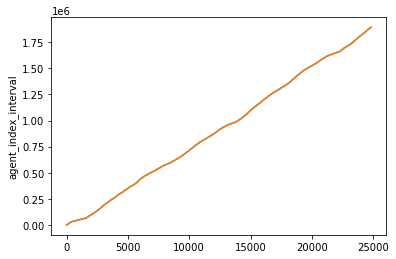

In [48]:
plt.plot(frames['agent_index_interval'][:,0])
plt.plot(frames['agent_index_interval'][:,1])
plt.ylabel('agent_index_interval')
plt.show()

In [22]:
display(frames['traffic_light_faces_index_interval'],stats.describe(frames['agent_index_interval']))  

array([[     0,      0],
       [     0,      0],
       [     0,      0],
       ...,
       [315954, 315972],
       [315972, 315990],
       [315990, 316008]])

DescribeResult(nobs=24838, minmax=(array([ 0, 38]), array([1893690, 1893736])), mean=array([915997.46815364, 916073.7116515 ]), variance=array([3.06904671e+11, 3.06909373e+11]), skewness=array([0.03319856, 0.03318825]), kurtosis=array([-1.2168344 , -1.21681771]))

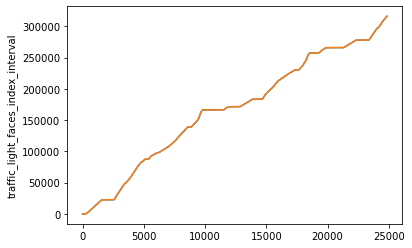

In [49]:
plt.plot(frames['traffic_light_faces_index_interval'][:,0])
plt.plot(frames['traffic_light_faces_index_interval'][:,1])
plt.ylabel('traffic_light_faces_index_interval')
plt.show()

In [23]:
display(frames['ego_translation'],stats.describe(frames['agent_index_interval']))  

array([[  680.61975098, -2183.32763672,   288.5411377 ],
       [  681.18560791, -2182.42236328,   288.60812378],
       [  681.76470947, -2181.52270508,   288.68093872],
       ...,
       [  277.59262085,    38.04537201,   269.52923584],
       [  277.59915161,    38.03862   ,   269.53125   ],
       [  277.59915161,    38.03862   ,   269.53125   ]])

DescribeResult(nobs=24838, minmax=(array([ 0, 38]), array([1893690, 1893736])), mean=array([915997.46815364, 916073.7116515 ]), variance=array([3.06904671e+11, 3.06909373e+11]), skewness=array([0.03319856, 0.03318825]), kurtosis=array([-1.2168344 , -1.21681771]))

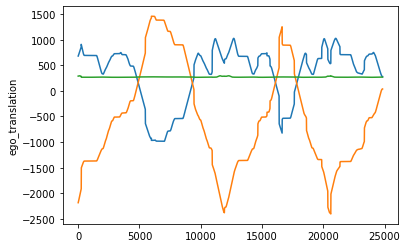

In [52]:
plt.plot(frames['ego_translation'][:,0])
plt.plot(frames['ego_translation'][:,1])
plt.plot(frames['ego_translation'][:,2])

plt.ylabel('ego_translation')
plt.show()

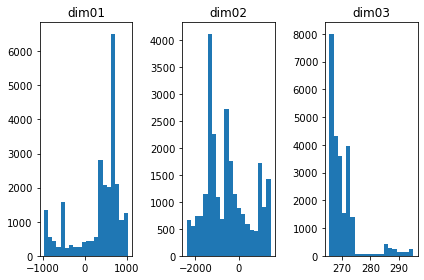

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=3)
ax0, ax1, ax2 = axes.flatten()

ax0.hist(frames['ego_translation'][:,0], histtype='bar', bins = 20)
ax0.set_title('dim01')

ax1.hist(frames['ego_translation'][:,1], histtype='bar',  bins = 20)
ax1.set_title('dim02')

ax2.hist(frames['ego_translation'][:,2], histtype='bar',  bins = 20)
ax2.set_title('dim03')

fig.tight_layout()
plt.show()


In [24]:
display(frames['ego_rotation'],stats.describe(frames['agent_index_interval']))  

array([[[ 5.46733141e-01, -8.37294340e-01,  4.59085545e-03],
        [ 8.35287392e-01,  5.45025647e-01, -7.24018440e-02],
        [ 5.81195243e-02,  4.34191711e-02,  9.97364998e-01]],

       [[ 5.47081292e-01, -8.37059736e-01,  5.74750407e-03],
        [ 8.35097909e-01,  5.45301139e-01, -7.25131184e-02],
        [ 5.75636923e-02,  4.44702990e-02,  9.97350872e-01]],

       [[ 5.47960341e-01, -8.36487472e-01,  5.30776521e-03],
        [ 8.34573150e-01,  5.46253383e-01, -7.13788122e-02],
        [ 5.68080992e-02,  4.35424782e-02,  9.97435153e-01]],

       ...,

       [[-6.85727835e-01, -7.27773726e-01,  1.10812755e-02],
        [ 7.27855563e-01, -6.85606301e-01,  1.30493855e-02],
        [-1.89960725e-03,  1.70138944e-02,  9.99853432e-01]],

       [[-6.85727835e-01, -7.27758884e-01,  1.20140575e-02],
        [ 7.27857947e-01, -6.85625672e-01,  1.18446993e-02],
        [-3.82939004e-04,  1.68667678e-02,  9.99857664e-01]],

       [[-6.85727835e-01, -7.27758884e-01,  1.20140575e-02],
 

DescribeResult(nobs=24838, minmax=(array([ 0, 38]), array([1893690, 1893736])), mean=array([915997.46815364, 916073.7116515 ]), variance=array([3.06904671e+11, 3.06909373e+11]), skewness=array([0.03319856, 0.03318825]), kurtosis=array([-1.2168344 , -1.21681771]))

## `agents` object

In [65]:
agents

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>

In [66]:
display(agents['centroid'].shape)
display(agents['extent'].shape)
display(agents['yaw'].shape)
display(agents['velocity'].shape)
display(agents['track_id'].shape)
display(agents['label_probabilities'].shape)

(1893736, 2)

(1893736, 3)

(1893736,)

(1893736, 2)

(1893736,)

(1893736, 17)

In [25]:
display(agents['centroid'],stats.describe(agents['centroid']))  

array([[  665.03424072, -2207.51220703],
       [  717.66125488, -2173.76000977],
       [  730.68139648, -2180.67895508],
       ...,
       [  227.16343689,    73.98806   ],
       [  213.86314392,    75.33246613],
       [  293.89666748,    37.07797241]])

DescribeResult(nobs=1893736, minmax=(array([-1111.62402344, -2527.59692383]), array([1179.10778809, 1538.58007812])), mean=array([ 336.96958476, -510.95629091]), variance=array([289721.02287455, 952730.00732782]), skewness=array([-1.21068585,  0.34476435]), kurtosis=array([ 0.29362059, -0.64710993]))

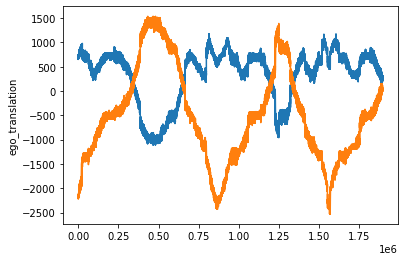

In [54]:
plt.plot(agents['centroid'][:,0])
plt.plot(agents['centroid'][:,1])

plt.ylabel('ego_translation')
plt.show()

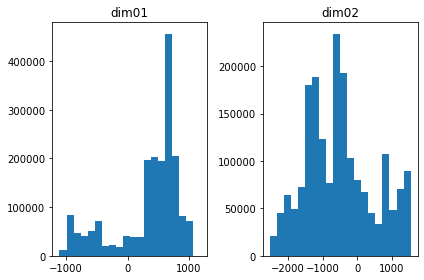

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes.flatten()

ax0.hist(agents['centroid'][:,0], histtype='bar', bins = 20)
ax0.set_title('dim01')

ax1.hist(agents['centroid'][:,1], histtype='bar',  bins = 20)
ax1.set_title('dim02')


fig.tight_layout()
plt.show()


In [26]:
display(agents['extent'],stats.describe(agents['extent']))  

array([[ 4.3913283 ,  1.8138304 ,  1.5909758 ],
       [ 5.150925  ,  1.9530917 ,  2.04021   ],
       [ 2.9482825 ,  1.4842174 ,  1.1125067 ],
       ...,
       [ 2.024245  ,  0.3544109 ,  0.8435698 ],
       [ 0.51277804,  1.2809446 ,  1.1334285 ],
       [ 6.1831617 , 20.55534   ,  1.9852563 ]], dtype=float32)

DescribeResult(nobs=1893736, minmax=(array([0.00122785, 0.00101208, 0.00396568], dtype=float32), array([43.27387 , 34.118965,  4.470044], dtype=float32)), mean=array([1.7873503, 1.4478683, 1.0951946], dtype=float32), variance=array([3.8989289 , 3.6968918 , 0.27959338], dtype=float32), skewness=array([3.343305  , 6.219854  , 0.23232752], dtype=float32), kurtosis=array([21.682962 , 53.15262  , -0.3010471], dtype=float32))

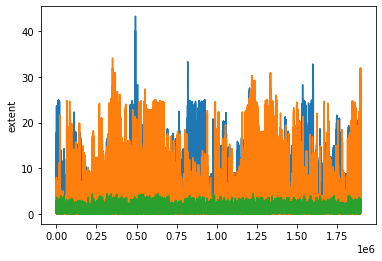

In [55]:
plt.plot(agents['extent'][:,0])
plt.plot(agents['extent'][:,1])
plt.plot(agents['extent'][:,2])

plt.ylabel('extent')
plt.show()

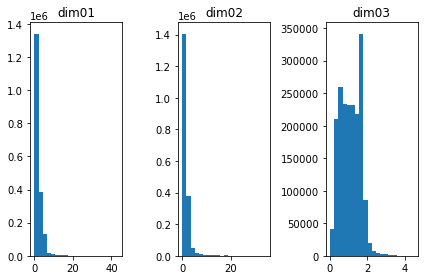

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=3)
ax0, ax1, ax2 = axes.flatten()

ax0.hist(agents['extent'][:,0], histtype='bar', bins = 20)
ax0.set_title('dim01')

ax1.hist(agents['extent'][:,1], histtype='bar',  bins = 20)
ax1.set_title('dim02')

ax2.hist(agents['extent'][:,2], histtype='bar',  bins = 20)
ax2.set_title('dim03')

fig.tight_layout()
plt.show()


In [27]:
display(agents['yaw'],stats.describe(agents['yaw']))  

array([ 1.0166751, -0.783224 , -0.321747 , ...,  0.9426058, -0.8095717,
        0.7302229], dtype=float32)

DescribeResult(nobs=1893736, minmax=(-3.1415882, 3.1415925), mean=0.5978983, variance=1.3702791, skewness=-0.7967497706413269, kurtosis=0.793039374252527)

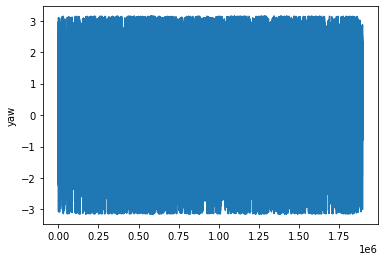

In [56]:
plt.plot(agents['yaw'])

plt.ylabel('yaw')
plt.show()

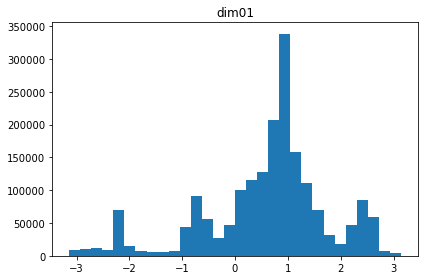

In [79]:
fig, ax0 = plt.subplots()

ax0.hist(agents['yaw'], histtype='bar', bins = 30)
ax0.set_title('dim01')


fig.tight_layout()
plt.show()


In [28]:
display(agents['velocity'],stats.describe(agents['velocity']))  

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [-0.09165736,  3.9186544 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]], dtype=float32)

DescribeResult(nobs=1893736, minmax=(array([-30.488567, -25.589865], dtype=float32), array([24.13901 , 27.416363], dtype=float32)), mean=array([-0.00771686,  0.01283908], dtype=float32), variance=array([4.992083, 5.921431], dtype=float32), skewness=array([-0.14804219,  0.11428794], dtype=float32), kurtosis=array([16.620152, 17.446934], dtype=float32))

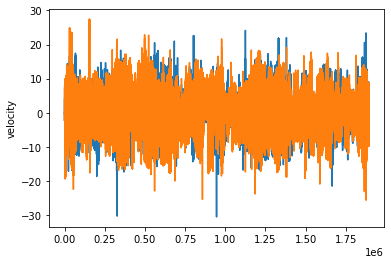

In [57]:
plt.plot(agents['velocity'][:,0])
plt.plot(agents['velocity'][:,1])

plt.ylabel('velocity')
plt.show()

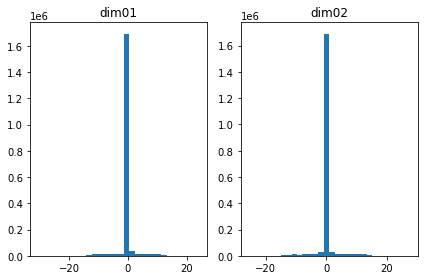

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes.flatten()

ax0.hist(agents['velocity'][:,0], histtype='bar', bins = 30)
ax0.set_title('dim01')

ax1.hist(agents['velocity'][:,1], histtype='bar',  bins = 30)
ax1.set_title('dim02')


fig.tight_layout()
plt.show()

In [29]:
display(agents['track_id'],stats.describe(agents['track_id']))  

array([   1,    2,    3, ..., 1481, 1483, 1485], dtype=uint64)

DescribeResult(nobs=1893736, minmax=(1, 2547), mean=579.6444097804551, variance=242477.28710599928, skewness=0.8003135039285614, kurtosis=-0.10558233520525828)

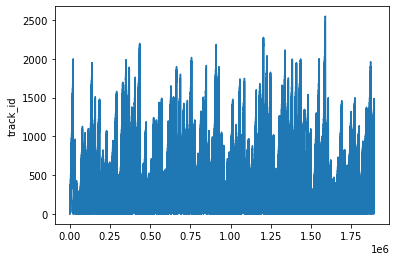

In [58]:
plt.plot(agents['track_id'])
plt.ylabel('track_id')
plt.show()



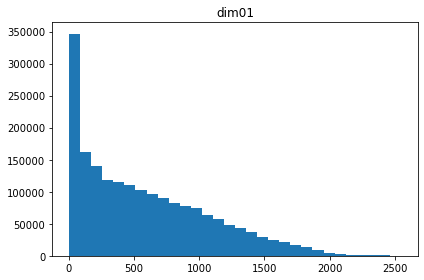

In [82]:
fig, ax0 = plt.subplots()

ax0.hist(agents['track_id'], histtype='bar', bins = 30)
ax0.set_title('dim01')


fig.tight_layout()
plt.show()


## `scenes` object

In [67]:
scenes

<zarr.core.Array '/scenes' (100,) [('frame_index_interval', '<i8', (2,)), ('host', '<U16'), ('start_time', '<i8'), ('end_time', '<i8')] read-only>

In [68]:
display(scenes['frame_index_interval'].shape)
display(scenes['host'].shape)
display(scenes['start_time'].shape)
display(scenes['end_time'].shape)

(100, 2)

(100,)

(100,)

(100,)

In [30]:
display(scenes['frame_index_interval'],stats.describe(scenes['frame_index_interval']))  

array([[    0,   248],
       [  248,   497],
       [  497,   746],
       [  746,   995],
       [  995,  1244],
       [ 1244,  1493],
       [ 1493,  1742],
       [ 1742,  1991],
       [ 1991,  2240],
       [ 2240,  2489],
       [ 2489,  2738],
       [ 2738,  2987],
       [ 2987,  3236],
       [ 3236,  3485],
       [ 3485,  3734],
       [ 3734,  3983],
       [ 3983,  4232],
       [ 4232,  4481],
       [ 4481,  4730],
       [ 4730,  4979],
       [ 4979,  5228],
       [ 5228,  5477],
       [ 5477,  5725],
       [ 5725,  5973],
       [ 5973,  6221],
       [ 6221,  6469],
       [ 6469,  6717],
       [ 6717,  6965],
       [ 6965,  7213],
       [ 7213,  7461],
       [ 7461,  7709],
       [ 7709,  7957],
       [ 7957,  8205],
       [ 8205,  8453],
       [ 8453,  8701],
       [ 8701,  8949],
       [ 8949,  9197],
       [ 9197,  9445],
       [ 9445,  9693],
       [ 9693,  9941],
       [ 9941, 10189],
       [10189, 10437],
       [10437, 10685],
       [106

DescribeResult(nobs=100, minmax=(array([  0, 248]), array([24590, 24838])), mean=array([12298.48, 12546.86]), variance=array([51883075.40363637, 51881233.87919192]), skewness=array([-0.00046403, -0.00037891]), kurtosis=array([-1.19898191, -1.19900873]))

In [13]:
display(scenes['host'])  
display(np.unique(scenes['host']))

array(['host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a013', 'host-a013',
       'host-a013', 'host-a013', 'host-a013', 'host-a101', 'host-a101',
       'host-a101', 'host-a101', 'host-a101', 'host-a101', 'host-a101',
       'host-a101', 'host-a101', 'host-a101', 'host-a101', 'host-a101',
       'host-a101', 'host-a101', 'host-a101', 'host-a101', 'host-a101',
       'host-a101', 'host-a101', 'host-a101', 'host-a101', 'host

array(['host-a013', 'host-a101'], dtype='<U16')

In [34]:
display(scenes['start_time'],stats.describe(scenes['start_time']))  

array([1572643684617362176, 1572643749559148288, 1572643774559148288,
       1572643799559148288, 1572643824559148288, 1572643849559148288,
       1572643874559148288, 1572643899559148288, 1572643924559148288,
       1572643949559148288, 1572643974559148288, 1572643999559148288,
       1572644024559148288, 1572644049559148288, 1572644074559148288,
       1572644099559148288, 1572644124559148288, 1572644149559148288,
       1572644174559148288, 1572644199559148288, 1572644224559148288,
       1572644249559148288, 1572644318672167168, 1572644343672167168,
       1572644439610481408, 1572644464610481408, 1572644489610481408,
       1572644514610481408, 1572644539610481408, 1572644564610481408,
       1572644589610481408, 1572644614610481408, 1572644639610481408,
       1572644664610481408, 1572644689610481408, 1572644714610481408,
       1572644739610481408, 1572644764610481408, 1572644816986979840,
       1572644841986979840, 1572644866986979840, 1572644891986979840,
       1572644916986

DescribeResult(nobs=100, minmax=(1571086539890067456, 1572645101725150464), mean=1.5719633898684303e+18, variance=4.986800997154398e+29, skewness=-0.24249281267294162, kurtosis=-1.7300273832362423)

In [35]:
display(scenes['end_time'],stats.describe(scenes['end_time']))  

array([1572643709617362176, 1572643774559148288, 1572643799559148288,
       1572643824559148288, 1572643849559148288, 1572643874559148288,
       1572643899559148288, 1572643924559148288, 1572643949559148288,
       1572643974559148288, 1572643999559148288, 1572644024559148288,
       1572644049559148288, 1572644074559148288, 1572644099559148288,
       1572644124559148288, 1572644149559148288, 1572644174559148288,
       1572644199559148288, 1572644224559148288, 1572644249559148288,
       1572644274559148288, 1572644343672167168, 1572644368672167168,
       1572644464610481408, 1572644489610481408, 1572644514610481408,
       1572644539610481408, 1572644564610481408, 1572644589610481408,
       1572644614610481408, 1572644639610481408, 1572644664610481408,
       1572644689610481408, 1572644714610481408, 1572644739610481408,
       1572644764610481408, 1572644789610481408, 1572644841986979840,
       1572644866986979840, 1572644891986979840, 1572644916986979840,
       1572644941986

DescribeResult(nobs=100, minmax=(1571086564890067456, 1572645126725150464), mean=1.5719634148684303e+18, variance=4.986800997154398e+29, skewness=-0.24249281267294162, kurtosis=-1.7300273832362423)

## `tl_faces` object

In [8]:
tl_faces

<zarr.core.Array '/traffic_light_faces' (316008,) [('face_id', '<U16'), ('traffic_light_id', '<U16'), ('traffic_light_face_status', '<f4', (3,))] read-only>

In [9]:
display(tl_faces['face_id'].shape)
display(tl_faces['traffic_light_id'].shape)
display(tl_faces['traffic_light_face_status'].shape)

(316008,)

(316008,)

(316008, 3)

In [10]:
display(tl_faces['face_id'])
display(np.unique(tl_faces['face_id']))

array(['xbVG', 'jutE', 'CDDo', ..., '16Ac', 'Wmr4', '16Ac'], dtype='<U16')

array(['++7C', '+C+9', '+IMm', '+IlQ', '+Y8k', '+Zo/', '+vGi', '/JTg',
       '/MpV', '/NIJ', '0R2C', '0e+E', '0kHT', '15cS', '16Ac', '19IQ',
       '1CZJ', '1EuM', '1GKi', '1eFh', '1wgG', '2SJF', '2gxN', '2hYz',
       '35BX', '3f5k', '3mZw', '4jic', '50H4', '5Qxt', '5Rp8', '5Ueq',
       '5Ulh', '5hxo', '62GG', '63+P', '64tI', '66yp', '6A5W', '75E5',
       '7J3p', '7fNs', '7iuD', '82Zj', '8Pyb', '8gQQ', '8nGm', '8oxi',
       '9+Ru', '95kG', '9bGo', 'A5zi', 'A9Ng', 'AAQ/', 'AGcF', 'AbX9',
       'Ak84', 'BYPY', 'C/dE', 'CDDo', 'Cd6g', 'D0xj', 'D9GY', 'DAYq',
       'DMti', 'DeII', 'Dm15', 'DnEU', 'DyJc', 'EOZP', 'Eyhn', 'FCSR',
       'FG59', 'FGsm', 'FM10', 'Fndm', 'FqB1', 'GRKe', 'Gl2x', 'H/Q+',
       'HBZs', 'HJGV', 'HLW8', 'HPZq', 'HWMB', 'IHnG', 'Ibe5', 'JN1t',
       'JiFB', 'Jnpc', 'JuLu', 'K4eP', 'K7NR', 'K9Zd', 'KO4R', 'KPuo',
       'KVun', 'Kc1Z', 'L8iO', 'M2Ag', 'M2zn', 'MFLI', 'MGkm', 'Mduj',
       'MsjE', 'MwZN', 'MzSo', 'N0ns', 'N36h', 'NQfE', 'O5qn', 'OD0J',
      

In [11]:
display(tl_faces['traffic_light_id'])
display(np.unique(tl_faces['traffic_light_id']))

array(['/ggb', '/ggb', '/ggb', ..., 'yYeP', 'yYeP', 'yYeP'], dtype='<U16')

array(['/ggb', '0E3j', '2mol', '2yCV', '3VcD', '3WL8', '3YQd', '3eWK',
       '4AM3', '4Xis', '4nUd', '5Ike', '8qGJ', '9j54', '9sh4', 'AETt',
       'APRT', 'Ae1d', 'CkJa', 'CqSo', 'DDUl', 'EnjI', 'FlE6', 'H6SN',
       'HW8C', 'Ku83', 'LEdD', 'LL1i', 'LhR9', 'MfzU', 'NTTe', 'O++3',
       'Pdat', 'QEpZ', 'R584', 'RDa4', 'RR43', 'RjTd', 'RsPp', 'STkk',
       'T4tC', 'UWVz', 'VEcT', 'VUk/', 'XSAD', 'YCly', 'YTDn', 'Ya58',
       'a7+8', 'aBqp', 'aHR8', 'aLv7', 'ai54', 'axuZ', 'b8F3', 'ciok',
       'cvA3', 'cyCW', 'ePt3', 'gwNT', 'h0Eo', 'h4rU', 'hc0L', 'j9IT',
       'jI/X', 'jzLD', 'lU4X', 'lZcz', 'ls3Z', 'm558', 'mBh/', 'nuVl',
       'o39e', 'ox+T', 'pmaD', 'qWWK', 'rO/q', 'tuOM', 'umZo', 'uz2Z',
       'vW1d', 'wBXk', 'yYeP', 'yg28', 'zwm4'], dtype='<U16')

In [12]:
display(tl_faces['traffic_light_face_status'])
display(np.unique(tl_faces['traffic_light_face_status']))

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

array([0., 1.], dtype=float32)